# Przetwarzanie języka naturalnego w Pythonie

Ten notatnik ma na celu przedstawienie podstawowych kroków, które należy wykonać podczas analizy i klasyfikacji tekstów. W trakcie zadania będziemy tworzyć szereg funkcji pomocniczych, które na koniec wykorzystamy do klasyfikacji krótkich dokumentów tekstowych.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega i jak wykonać tokenizację,
+ potrafić wykonać podstawowy stemming,
+ potrafić analizować najpopularniejsze i narzadsze tokeny w zbiorze dokumentów,
+ zdefiniować i usunąć stopwords,
+ wiedzieć jak zamienić zbiór dokumentów na reprezentację bag-of-words,
+ uruchomić wybrany klasyfikator na przetworzonym zbiorze danych.

## Przygotowanie

Na początek trochę bibliotek i przydatnych wyrażeń regularnych:

In [1]:
import re
import pandas as pd
import nltk

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

Biblioteka [re](https://docs.python.org/2/library/re.html) pozwala definiować wyrażenia regularne, [pandas](http://pandas.pydata.org/) już znasz z ostatnich zajęć, a [nltk](http://www.nltk.org/) to podstawowa biblioteka do przetwarzania języka naturalnego w pythonie. `nltk` to spory zestaw modułów, który domyślnie nie jest instalowany w całości. Aby doinstalować wybrane moduły możesz w interaktywnej konsoli pythona wpisać:

`import nltk
nltk.download()`

Następnie w odpowiednich zakładkach wybrać interesujące moduły. W ramach tego ćwiczenia będziemy wykorzystywać moduł **`punkt`** z zakładki Modules, ale proszę zwrócić uwagę na interesujące korpusy i leksykony, takie jak np. `opinion_lexicon` czy `sentiwordnet`.

Przyda nam się też zbiór danych do testowania kodu.

**Zad. 1: Wczytaj zbiór danych `tweets_train.tsv` do zmiennej `tweets`. Pomiń nagłówek i pozostaw tylko ostatnią kolumnę. Wyświetl pierwsze 6 wierszy, żeby upewnić się, że każdy przykład składa się tylko z tekstu.**

In [17]:
tweets = pd.read_csv('tweets_train.tsv', header=None, sep='\t')[2]
tweets.head(6)

0    dear @Microsoft the newOoffice for Mac is grea...
1    @Microsoft how about you make a system that do...
2                                        Not Available
3                                        Not Available
4    If I make a game as a #windows10 Universal App...
5    Microsoft, I may not prefer your gaming branch...
Name: 2, dtype: object

## Tokenizacja i stemming

Żeby uporządkować trochę kod i kolejne kroki, wprowadźmy klasę Tokenizer i BeforeTokenizationNormalizer. Pierwsza będzie służyć jako klasa bazowa dla tworzonych przez tokenizatorów a druga zamieni encje html na poprawne znaki tekstowe.

In [14]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass
    
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text

Aby sprawdzić czy wszystko działa - odkomentuj poniższy kod:

In [18]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    print(tweet)

dear @microsoft the newooffice for mac is great and all, but no lync update? c'mon.
@microsoft how about you make a system that doesn't eat my friggin discs. this is the 2nd time this has happened and i am so sick of it!
not available
not available
if i make a game as a #windows10 universal app. will #xboxone owners be able to download and play it in november? @majornelson @microsoft
microsoft, i may not prefer your gaming branch of business. but, you do make a damn fine operating system. #windows10 @microsoft
@mikewolf1980 @microsoft i will be downgrading and let #windows10 be out for almost the 1st yr b4 trying it again. #windows10fail
@microsoft 2nd computer with same error!!! #windows10fail guess we will shelve this until sp1! http://t.co/qcchlkuy8q
just ordered my 1st ever tablet; @microsoft surface pro 3, i7/8gb 512gb ssd. hopefully it works out for dev to replace my laptop =)
after attempting a reinstall, it still bricks, says, "windows cannot finish installing," or somesuch. @m

W kolejnych krokach będziesz implementował coraz bardziej wyrafinowane tokenizatory. Zacznijmy od czegoś w miarę intuicyjnego.

**Zad. 2: Napisz tokenizator, który dzieli słowa według spacji. Tokenizator powinien przyjmować tekst (pojedynczego stringa) i zamieniać go na listę słów. Przetestuj kod za pomocą zakomentowanej pętli.**

In [21]:
class SimpleTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Można w tym celu wykorzystać wyrażenie RE_SPACES. Jakie wady ma takie podejście? Jak reaguje na znaki
        # interpunkcyjne? Jeśli usuniesz interpunkcje, co się dzieje ze skrótowcami? Jak obsłużyć słowa can't, o'clock,
        # we'd itp.?
        return RE_SPACES.split(text)

In [22]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_simple = SimpleTokenizer.tokenize(tweet)
    print(words_simple)

['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all,', 'but', 'no', 'lync', 'update?', "c'mon."]
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', "doesn't", 'eat', 'my', 'friggin', 'discs.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#windows10', 'universal', 'app.', 'will', '#xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november?', '@majornelson', '@microsoft']
['microsoft,', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business.', 'but,', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system.', '#windows10', '@microsoft']
['@mikewolf1980', '@microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'trying', 'it', 'again.', '#windows10fail']
['@micro

**Zad. 3: Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.**

In [27]:
nltk.download('punkt')

class NltkTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.
        # Czy w przypadku tweetów wszystkie słowa zostały poprawnie rozdzielone?
        return nltk.word_tokenize(text)

[nltk_data] Downloading package punkt to /home/bartosz-
[nltk_data]     mikulski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_nltk = NltkTokenizer.tokenize(tweet)
    print(words_nltk)

['dear', '@', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'does', "n't", 'eat', 'my', 'friggin', 'discs', '.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#', 'windows10', 'universal', 'app', '.', 'will', '#', 'xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november', '?', '@', 'majornelson', '@', 'microsoft']
['microsoft', ',', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business', '.', 'but', ',', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system', '.', '#', 'windows10', '@', 'microsoft']
['@', 'mikewolf1980', '@', 'microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#', 'windows10', 'be', 'out', 'fo

['angela', 'merkel', "'s", 'jackets', ':', 'many', 'colours', 'but', 'just', 'one', 'look', 'http', ':', '//t.co/ifvnbuqfgf']
['apparently', 'germany', 'leads', 'the', 'way', '.', 'well', 'done', 'angela', 'merkel', '.', 'http', ':', '//t.co/z4d0iflavq']
['did', 'you', 'know', 'that', "'angela", 'merkel', "'", 'was', 'trending', 'topic', 'on', 'wednesday', '2', 'for', '6', 'hours', 'in', 'sweden', '?', 'http', ':', '//t.co/lsi57oqqi0', '#', 'trndnl']
['god', 'bless', 'angela', 'merkel', 'and', 'the', 'people', 'of', 'germany', '.', '.', '.', 'leading', 'the', 'way', '.', 'may', 'the', 'uk', 'government', 'follow', 'their', 'example', 'http', ':', '//t.co/gral0rmwv4']
['not', 'available']
['@', 'smith_rfkennedy', '@', 'nishelo', 'why', 'nobody', 'have', 'ever', 'said', 'it', 'about', 'any', 'country', 'outside', 'africa', '?', ':', 'why', 'angela', 'merkel', 'ran', 'again', 'for', 'a', '3rd', 'term', '?']
['chancellor', 'angela', 'merkel', 'leading', 'the', '#', 'exodus', 'march', 'to',

**Zad. 4: Napisz tokenizator, który oprócz standardowych słów obsłuży emitikony i hashtagi. Następnie wykonaj stemming (porter = nltk.PorterStemmer() porter.stem()).**

In [90]:
class TweetTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        processed_tokens = []
        for token in tokens:
            match = [pattern.match(token) for pattern in [RE_EMOTICONS, RE_HASHTAG, RE_HTTP]]
            match = [m for m in match if m]
            if match:
                # wydziel emotikonę lub hashtag jako token a resztę tekstu rozpatrz ponownie
                if match[0].re is not RE_HTTP:
                    s, e = match[0].span()
                    processed_tokens.append(token[s:e])
            else:
                processed_tokens += NltkTokenizer.tokenize(token)
        
        porter = nltk.PorterStemmer()
        return [porter.stem(token) for token in processed_tokens]

In [91]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_tweet = TweetTokenizer.tokenize(tweet)
    print(words_tweet)

['dear', '@microsoft', 'the', 'newooffic', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'updat', '?', "c'mon", '.']
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'doe', "n't", 'eat', 'my', 'friggin', 'disc', '.', 'thi', 'is', 'the', '2nd', 'time', 'thi', 'ha', 'happen', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'avail']
['not', 'avail']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#windows10', 'univers', 'app', '.', 'will', '#xboxon', 'owner', 'be', 'abl', 'to', 'download', 'and', 'play', 'it', 'in', 'novemb', '?', '@majornelson', '@microsoft']
['microsoft', ',', 'i', 'may', 'not', 'prefer', 'your', 'game', 'branch', 'of', 'busi', '.', 'but', ',', 'you', 'do', 'make', 'a', 'damn', 'fine', 'oper', 'system', '.', '#windows10', '@microsoft']
['@mikewolf1980', '@microsoft', 'i', 'will', 'be', 'downgrad', 'and', 'let', '#windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'tri', 'it', 'again', '.', '#windows10fail

['@ericfish', '@cbsboston', 'eric', ',', 'how', 'is', 'the', 'weather', 'for', 'the', 'ac/dc', 'concert', 'tomorrow', 'night', 'at', 'gillett', 'look', '?']
['surpris', 'my', 'mom', 'with', 'ac/dc', 'ticket', 'for', 'wednesday', '.', 'just', 'go', 'to', 'show', 'up']
['sit', '14th', 'row', 'for', 'ac/dc', 'tonight', '!', '!', 'let', "'s", 'go', '!']
['not', 'avail']
['have', 'dinner', 'with', '@maysoonzayid', 'to', 'plan', '12th', 'annual', 'ny', 'arab', 'american', 'comedi', 'festiv', 'and', 'ac/dc', 'walk', 'in', '.', 'but', 'could', "n't", 'get', 'a', 'photo']
['@jakeareid', 'plan', 'on', 'ac/dc', 'live', 'in', 'moncton', '?', 'come', 'up', 'sooner', 'than', 'later', ',', 'in', 'montreal', 'on', 'the', '31st', '.', 'at', 'the', 'big', '``', 'o', "''", '.']
['@smilelikepink', 'i', 'like', 'scorpion', ',', 'gun', ',', 'ac/dc', ',', 'i', 'download', 'u', 'play', 'yesterday', 'caus', "c'mon", 'it', "'s", 'beatl']
['angu', 'young', "'s", 'cap', 'flew', 'off', 'six', 'song', 'into', 'ac/d

['@marnie_rich', 'just', 'finish', '#thegirlwho', 'pt2', ',', 'wow', '!', 'just', 'wow', '!', 'you', 'got', 'a', 'date', 'for', 'part', '3', 'yet', '?', 'amazon', 'is', 'say', 'march', '16', 'but', 'ad', 'say', 'octob', '15', '?']
['tri', 'to', 'watch', 'ani', 'given', 'sunday', 'on', 'amazon', 'prime', 'and', 'there', "'s", 'big', 'chunk', 'of', 'the', 'film', 'cut', 'out']
['good', 'to', 'see', '@eamonngriffin', 'new', 'book', 'avail', 'in', 'hard', 'copi', '.', 'amazon', 'prime', 'bring', 'it', 'tomorrow', '.']
['on', 'the', 'ball', ',', '@amazon', '2', 'email', 'today', 'announc', 'that', 'clarkson', ',', 'hammond', 'and', 'may', 'are', 'to', 'make', 'a', 'seri', 'about', 'car', 'for', 'amazon', 'prime', '!', 'who', 'knew', '?']
['i', 'have', 'discov', 'that', 'bobbi', "'s", 'world', 'ha', 'unlimit', 'stream', 'on', 'amazon', 'prime', '.', 'i', 'may', 'or', 'may', 'not', 'be', 'watch', 'it', 'while', 'i', "'m", 'on', 'the', 'bike', '.']
['head', 'up', ':', 'an', 'import', 'chang', 

['market', '&', 'sale', ',', '3', 'market', 'lesson', 'from', 'amazon', 'prime', 'day', ':', 'even', 'though', 'the', 'social', 'media', 'world', 'may', 'h', '...', 'modesto']
['by', 'suzann', 'moor', ',', 'monday', '13', 'juli', '2015', 'the', 'guardian', 'thi', 'time', ',', 'it', "'s", 'not', 'me', 'who', 'say', 'that', '!', '//ro', 'angela', 'merkel', 'and', '...']
['doe', '@macleansmag', 'still', 'believ', 'that', 'ms', '.', 'angela', 'merkel', 'is', 'the', '``', 'real', 'leader', 'of', 'the', 'free', 'world', "''", '?', '(', 'greek', 'may', 'disagre']
['varoufaki', 'may', 'have', 'some', 'expertis', 'in', 'game', 'theori', ',', 'but', 'angela', 'merkel', 'is', 'the', 'grand', 'master', 'of', 'the', 'game']
['alexi', 'tsipra', 'to', 'angela', 'merkel', '-', 'earli', 'monday', 'morn', '-', 'take', 'hi', 'jacket', 'off', 'and', 'give', 'it', 'to', 'merkel', ',', 'say', ':', '``', 'do', 'you', 'want', 'thi', 'too', '?', "''"]
['on', 'anoth', 'note', ',', 'it', 'seem', 'greek', 'pm', '

W wielu zastosowaniach dobrze działa lematyzacja, która również jest dostępna w `nltk`. W tym ćwiczeniu pozostaniemy jednak przy stemmingu.

## Stopwords

W tej części przeanalizujemy częstość występowania różnych słów w korpusie. Interesują nas słowa występujące najczęściej i najrzadziej. Ich analiza pozwoli określić jakie słowa powinny zostać pominięte podczas analizy a jakie powinny zostać połączone w grupy znaczeniowe.

W tym celu przyda nam się jakaś struktura danych do zliczania słów oraz funkcja do rysowania histogramów.

In [92]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
sns.set_color_codes("muted")

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

Zacznijmy od zliczenia unikatowych słów. Pomoże nam w tym klasa [Counter](https://docs.python.org/2/library/collections.html#collections.Counter). Poniższy kod wypełnia kolekcję słowami po tokenizacji i stemmingu.

In [93]:
words = Counter()

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words.update(TweetTokenizer.tokenize(tweet))

**Zad. 5: Wypisz, zwizualizuj i przeanalizuj 50 najczęściej występujących słów. Czy wszystkie wyświetlone tokeny będą przydatne w dalszej analizie? Czy wszystkie tokeny to słowa?**

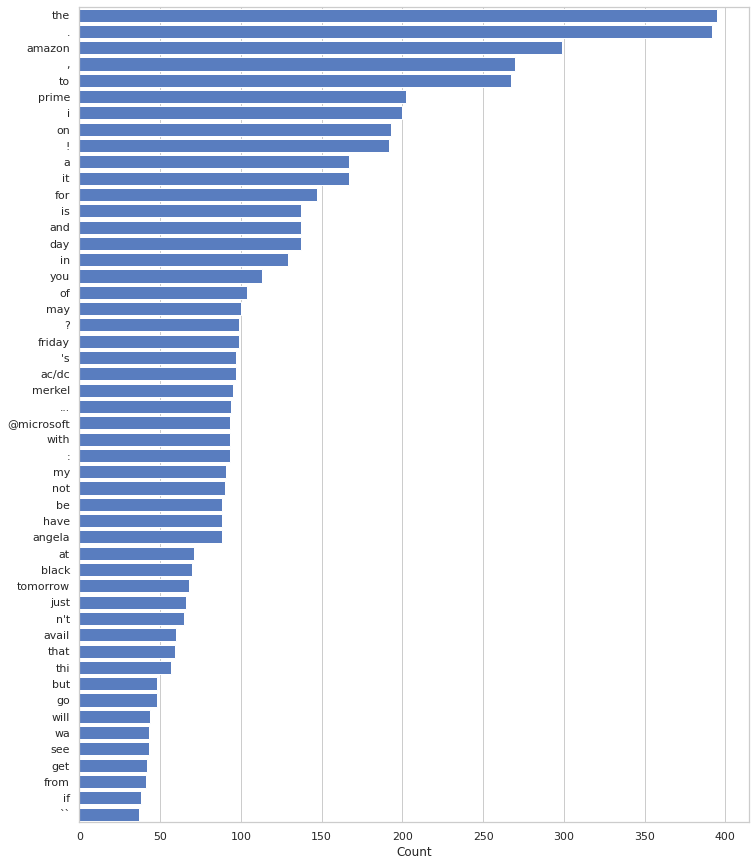

In [96]:
show_histogram(words.most_common(50))

Widać, że nie wszystkie tokeny to słowa. Ponieważ budujemy słownik słów, które będą wykorzystywane do klasyfikacji tekstów, usuńmy podstawowe tokeny, które nie niosą żadnej informacji.

**Zad. 6: Usuń znaki interpunkcyjne z kolekcji words i powtórz analizę. Czy w przypadku badania opinii trzeba wyrzucić wszystkie znaki interpunkcyjne?**

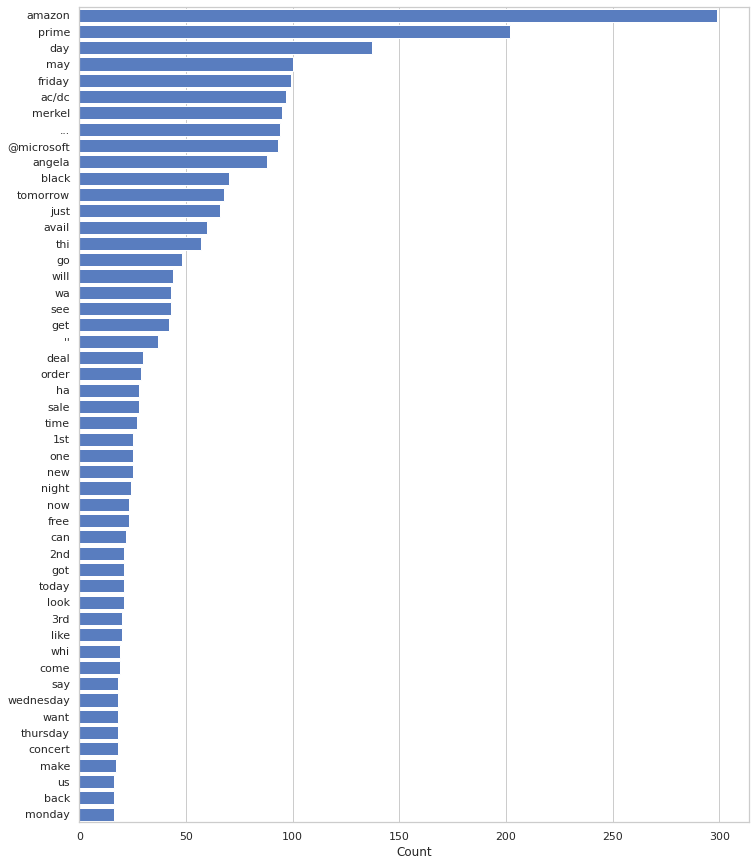

In [113]:
import string

keys = words.keys()
for key in keys:
    if all([char in string.punctuation for char in key]):
        words[key]

show_histogram(words.most_common(50))

Wyraźnie widać, że nawet bez znaków intepunkcyjnych pozostało dużo zbędnych tokenów. Poniżej lista słów, które często są oznaczane jako tzw. stopwords, czyli słowa występujące często a nie niosące informacji.

In [102]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him",
            "himself", "his", "how", "i", "in", "into", "is", "it", "its", "itself", "let", "me", "more", "most", "my",
            "myself", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "sha",
            "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves",
            "then", "there", "there's", "these", "they", "this", "those", "through", "to", "until", "up", "very",
            "was", "we", "were", "what", "when", "where", "which", "while", "who","whom", "with", "would", "you",
            "your", "yours", "yourself", "yourselves",
            "n't", "'s", "'ll", "'re", "'d", "'m", "'ve",
            "above", "again", "against", "below", "but", "cannot", "down", "few", "if", "no", "nor", "not", "off",
            "out", "over", "same", "too", "under", "why"]

**Zad. 7: Korzystając z listy `sotpwords` usuń z kolekcji `words` popularne stopwords i ponów analizę. Czy wszystkie stopwords zawsze należy wyrzucać? Czy słowa takie jak "not" mogą być nośnikiem opinii? Jeśli masz jeszcze dużo czasu, możesz przeanalizować listę słów w nltk.corpus.stopwords.words('english')?**

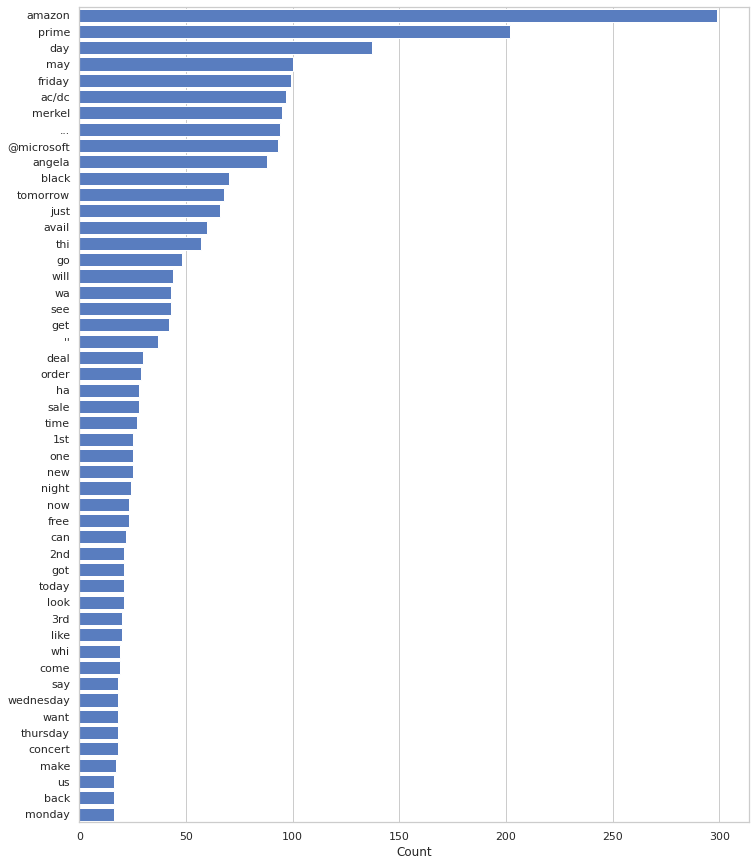

In [114]:
for s in stopwords:
    del words[s]
    
show_histogram(words.most_common(50))

Oprócz tokenów, które występują zbyt często, problemem bywają również najrzadsze tokeny.

**Zad. 8: Przeanalizuj 100 listę najrzadszych tokenów. Czy wszystkie tokeny są rzeczywiście rzadkie? Czy jakieś typy tokenów powtarzają się? Jak myślisz, co najlepiej zrobić z takimi tokenami jak 1, 2, 3... 10%, 20%, 30%..., 12:00, 19:50, 22:30, ..., 2005, 2010, 1995..., 10\$, 20\$, 30\$... ?**

In [120]:
not_popular_words = words.most_common()[-100:]
for i in range(0, 100, 5):
    print(not_popular_words[i:i+5])


[('illog', 1), ('democraci', 1), ('deutschen', 1), ('nazi', 1), ('accuss', 1)]
[('betray', 1), ('polic', 1), ('clear', 1), ('strong', 1), ('washington', 1)]
[('aug', 1), ('26', 1), ('barack', 1), ('voic', 1), ('conduct', 1)]
[('dnr', 1), ('lnr', 1), ('minsk', 1), ('agreement', 1), ('@paulaedwy', 1)]
[('tat', 1), ('azerbaijan', 1), ('youngish', 1), ('abe', 1), ("'they", 1)]
[('fellow', 1), ('stanc', 1), ('canadian', 1), ('zone', 1), ('reform', 1)]
[('#foxreg', 1), ('#thearkoftwitt', 1), ('800,000', 1), ('immigrants.that', 1), ('april.now', 1)]
[('digniti', 1), ('stood', 1), ('@ajweald', 1), ('telegraph', 1), ('passport', 1)]
[('admitt', 1), ('principl', 1), ('movement', 1), ('#googlealert', 1), ('btw', 1)]
[('biographi', 1), ('predecessor', 1), ('gerhard', 1), ('schroeder', 1), ('22', 1)]
[('@bild', 1), ('@telegraph', 1), ('prayer', 1), ('hungari', 1), ('budapest', 1)]
[('our.fath', 1), ('merkel.thank', 1), ('catalonia', 1), ('reappli', 1), ('seced', 1)]
[('spain', 1), ('#snp', 1), ('@k

Na tym etapie w zmiennej `words` mamy wstępnie przygotowany słownik. Jak widać słownik możnaby jeszcze ulepszyć, ale w tym ćwiczeniu poprzestaniemy na tym co do tej pory zrobiliśmy.

## Klasyfikacja

Mając słownik zamienimy przykłady uczące na reprezentację bag of words (BOW). W tej reprezentacji każdy przykład uczący (pojedynczy dokument tekstowy) przyjmuje formę wektora liczb. Każda pozycja w wektorze oznacza kolejne słowo ze słownika, a liczba na danej pozycji mówi czy (0-1) lub jak często (0-k) dane słowo występuje w tekście. Taka reprezentacja wektorowa ma tę zaletę, że można ją łatwo rozszerzać o dodatkowe atrybuty.

**Zad. 9: Przeanalizuj poniższy kod tworzący reprezentację bag-of-words. Co to jest `csr_matrix`? Czy wykorzystanie tej klasy jest konieczne?**

In [121]:
def create_bow(documents, features):
    row = []
    col = []
    data = []

    labels = []

    for i in documents.index:
        tweet = BeforeTokenizationNormalizer.normalize(documents.iloc[i, 2])
        label = documents.iloc[i, 1]
        tweet_tokens = TweetTokenizer.tokenize(tweet)

        labels.append(label)
        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

Na koniec wykorzystajmy dotychczasową wiedzę, żeby nauczyć i przetestować klasyfikator.

**Zad. 10: Sprawdź działanie klasyfikatora Random Forest na przetworzonych wcześniej danych. Jak na trafność klasyfikacji wpływa parametr min_word_count?**

In [122]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

min_word_count = 5

train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
common_words = list([k for k, v in words.most_common() if v > min_word_count])

feature_dict = {}
for word in common_words:
    feature_dict[word] = len(feature_dict)

print("Training classifier...")
X_train, y_train = create_bow(train_tweets, feature_dict)
list_of_labels = list(set(y_train))
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
classifier.fit(X_train, y_train)

print("Testing...")
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
X_test, y_test = create_bow(test_tweets, feature_dict)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.02941176 0.23809524 0.70666667]
Precision [0.33333333 0.18518519 0.60571429]
Recall    [0.01538462 0.33333333 0.848     ]
